# Langgraph 2: Graph with Interrupt

In [61]:
#########  LangGraph  ##########################
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

import panel as pn
from typing import TypedDict, Annotated, List, Sequence
from IPython.display import display, Markdown,Latex,Image

# Graph with interrupt

https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

This code defines a simple graph-based flow using nodes, states, and transitions between them, with each node performing a specific task in sequence. Here's a breakdown of the code:

### 1. **State Definition**

   ```python
   class State(TypedDict):
       input: str
       messages: Annotated[list, add_messages]
   ```
   - `State` is a custom data structure using `TypedDict` to define the types of state properties.
   - It has two fields:
     - `input`: a string input, likely used for carrying initial data.
     - `messages`: a list of messages, annotated for additional behavior, presumably where the flow can accumulate or modify output messages as it progresses through nodes.

### 2. **Node Functions**

   - Each node function (`node1`, `node2`, `node3`) modifies the `state` and then returns it. Each function performs the following:

     - **`node1`**: Starts by printing "Start node1" and sets `state["messages"]` to `["Output node1: I wanna go home"]`.
     - **`node2`**: Starts by printing "Start node2" and sets `state["messages"]` to `["Output node2: What's the problem with node1?"]`.
     - **`node3`**: Starts by printing "Start node3" and sets `state["messages"]` to `["node3: I am going home"]`.

   - Each node is designed to sequentially alter `state["messages"]` with a unique message.

### 3. **StateGraph Creation**

   ```python
   builder = StateGraph(State)
   builder.add_node("node1", node1)
   builder.add_node("node2", node2)
   builder.add_node("node3", node3)
   builder.set_entry_point("node1")
   ```
   - `StateGraph` is initialized with the `State` structure, which defines the state format that each node will manipulate.
   - Nodes `node1`, `node2`, and `node3` are added to the graph with corresponding functions.
   - `set_entry_point("node1")` designates `node1` as the starting point of the graph.

### 4. **Defining the Flow (Edges)**

   ```python
   builder.add_edge("node1", "node2")
   builder.add_edge("node2", "node3")
   builder.add_edge("node3", END)
   ```
   - These edges define the sequence in which nodes execute:
     - After `node1`, the flow proceeds to `node2`.
     - After `node2`, it moves to `node3`.
     - After `node3`, the process ends (`END`).

### 5. **Memory Setup and Graph Compilation**

   ```python
   memory = MemorySaver()
   graph = builder.compile(checkpointer=memory, interrupt_before=["node3"])
   ```
   - `MemorySaver()` is set up to track the state across the nodes, storing each step in memory.
   - `interrupt_before=["node3"]` indicates an interruption before `node3` executes, perhaps to review or change the state.

### 6. **Visualization of the Graph**

   ```python
   display(Image(graph.get_graph().draw_mermaid_png()))
   ```
   - Finally, the code generates and displays a graphical representation of the flow using `Mermaid` notation. Each node and edge of the graph will be displayed, showing how the flow progresses from `node1` to `node2` to `node3`.

### Summary

This code builds a simple stateful flow where:
- **Each node** changes the `state["messages"]`.
- **Flow** goes from `node1` ➔ `node2` ➔ `node3`.
- **Memory and interruption** allow state tracking and intervention before the final node.
- **Graph visualization** shows the flow for easier comprehension and debugging. 

This setup can be particularly useful in chatbot flows, decision trees, or automated process orchestration scenarios where states change sequentially through nodes.

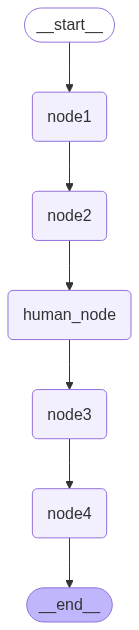

In [80]:
from langgraph.types import interrupt, Command
from langchain_core.messages import HumanMessage

class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node1 with latest message: {latest_message}")
    return {'messages' : "Here is some code" }


def node2(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node2 with latest message: {latest_message}")
    return {'messages' : "here is some more code" }


def node3(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node3 with latest message: {latest_message}")
    state["messages"]=["node3: I am going home"]
    return state 


builder = StateGraph(State)
builder.add_node("node1", node1)
builder.set_entry_point("node1")
builder.add_node("node2", node2)
builder.add_edge("node1", "node2")

def human_node(state: State):
    value = interrupt( 
        {
            "messages": "human node: this is the interrupt message",
        }
    )
    return {
        "messages": "human_node: this is the human response" 
    }
def node4(state: State):
    return Command(update = {"messages": [HumanMessage(content='node 4')  ]}, )
builder.add_node("human_node", human_node)
builder.add_edge("node2", "human_node")
builder.add_node("node3", node3)
builder.add_edge("human_node", "node3")
builder.add_node("node4", node4)
builder.add_edge("node3", "node4")
builder.add_edge("node4", END)
# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
from logging_config.logger import LOG
from langgraph.types import Command, interrupt
thread = {"configurable": {"thread_id": "3"}}  
def input_function(question:str, thread : dict = thread):
    input = {"input": question}
    out=[]
    current_state = graph.get_state(thread).values
    LOG.info(f"Current state before invoking graph: {current_state}")
    graph.update_state(thread,current_state)
    response = graph.invoke(input, thread )
    if response["messages"]:
        out.append(response["messages"][-1].content)
    # for state in graph.stream(input, thread, stream_mode="values"):
    #     out.append(state["messages"][-1].content)  
    LOG.info(f'Response from input function: {response}')
    answer="Graph : "+ "\n".join(out)
    print("Input_function : \n",answer)
    print('------')
    return answer
from langchain_core.messages import HumanMessage  # Make sure this is imported

def resume_function(human_response: str, thread: dict = thread):
    # Wrap the user response in a HumanMessage as expected by LangGraph
    human_message = HumanMessage(content=human_response)
    
    # Create a resumable command with the message
    human_command = Command(resume={"messages": [human_message]})
    
    # Invoke the graph with the resumable input
    response = graph.invoke(human_command, thread)
    
    out = []
    if response["messages"]:
        out.append(response["messages"][-1].content)
    
    LOG.info(f'Response from resume function: {response}')
    answer = "Graph after resume: " + "\n".join(out)
    print("Resume_function : \n", answer)
    print('------')
    return answer

        
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")
answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)



def button_click(event):
    print(f'number of clicks: {answer_button.clicks}')
    if answer_button.clicks == 1:
        bound_function = pn.bind(input_function, question)
        output.object = f"Answer:\n {bound_function()}"
    if answer_button.clicks > 1:
        bound_function = pn.bind(resume_function, question)
        output.object = f"Answer after resume:\n {bound_function()}"

answer_button.on_click(button_click)

Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:40739


In [82]:
from logging_config.logger import LOG
from langgraph.types import Command
from langchain_core.messages import HumanMessage
import panel as pn

pn.extension()

# Thread ID for conversation continuity
thread = {"configurable": {"thread_id": "3"}}

# --- Input function: first interaction ---
def input_function(question: str, thread: dict = thread):
    # Wrap the user question in a HumanMessage
    input_data = {"messages": [HumanMessage(content=question)]}
    out = []

    current_state = graph.get_state(thread).values
    LOG.info(f"Current state before invoking graph: {current_state}")
    graph.update_state(thread, current_state)

    # Invoke the graph
    response = graph.invoke(input_data, thread)
    if response["messages"]:
        out.append(response["messages"][-1].content)

    LOG.info(f'Response from input function: {response}')
    answer = "Graph: " + "\n".join(out)
    print("Input_function : \n", answer)
    print('------')
    return answer


# --- Resume function: handling human replies to interrupt ---
def resume_function(human_response: str, thread: dict = thread):
    # Wrap response as HumanMessage and resume
    human_message = HumanMessage(content=human_response)
    human_command = Command(resume={"messages": [human_message]})

    response = graph.invoke(human_command, thread)
    out = []
    if response["messages"]:
        out.append(response["messages"][-1].content)

    LOG.info(f'Response from resume function: {response}')
    answer = "Graph after resume: " + "\n".join(out)
    print("Resume_function : \n", answer)
    print('------')
    return answer


# --- Setup LangGraph ---
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# --- Panel UI Widgets ---
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")
answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)


# --- Button click handler ---
def button_click(event):
    print(f'number of clicks: {answer_button.clicks}')
    if answer_button.clicks == 1:
        bound_function = pn.bind(input_function, question)
        output.object = f"Answer:\n {bound_function()}"
    if answer_button.clicks > 1:
        bound_function = pn.bind(resume_function, question)
        output.object = f"Answer after resume:\n {bound_function()}"


# --- Attach click logic ---
answer_button.on_click(button_click)

# --- UI Layout ---
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


/tmp/ipykernel_1113509/4286671404.py:6: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension()


Launching server at http://localhost:36303


WATCHOUT 
if the input is :
- input : my_input_str, then it is not added to the State messages 
- messages : my_message_str, then it IS added to the State messages


In [83]:
memory.storage
all_thread_ids = list(memory.storage.keys())
all_thread_ids

[]

In [84]:
memory = MemorySaver()
graph2= builder.compile(checkpointer=memory)
thread2 = {"configurable": {"thread_id": "8"}}  # Ensure thread ID is set
current_state = graph2.get_state(thread2).values
current_state

{}

In [85]:
response = graph2.invoke({"messages": "yo"}, thread2)
response2 = graph2.invoke(Command(update={"messages": [HumanMessage(content='yo 2 ')]}), thread2)
response2

Start node1 with latest message: content='yo' additional_kwargs={} response_metadata={} id='a2fbcb8c-aafd-4511-8e4c-2e4879fabe64'
Start node2 with latest message: content='Here is some code' additional_kwargs={} response_metadata={} id='6a36a245-46ce-4ce7-b1ba-7c2644dfc7dd'


{'messages': [HumanMessage(content='yo', additional_kwargs={}, response_metadata={}, id='a2fbcb8c-aafd-4511-8e4c-2e4879fabe64'),
  HumanMessage(content='Here is some code', additional_kwargs={}, response_metadata={}, id='6a36a245-46ce-4ce7-b1ba-7c2644dfc7dd'),
  HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='30f26f10-9402-469c-855d-36ea93170ed8'),
  HumanMessage(content='yo 2 ', additional_kwargs={}, response_metadata={}, id='e4a054ea-5851-4278-b455-5bc1457574f2')],
 '__interrupt__': [Interrupt(value={'messages': 'human node: this is the interrupt message'}, resumable=True, ns=['human_node:38c5394f-2a83-bc6a-dba1-dd4d432cc71b'])]}

In [86]:
response3 = graph2.invoke(Command(resume={"messages": "yo 3 resume"}, update = {"messages": [HumanMessage(content='yo 3 update')]}, ), thread2)
response3

Start node3 with latest message: content='human_node: this is the human response' additional_kwargs={} response_metadata={} id='b7130acf-1f79-4e53-b789-35581593c767'


{'messages': [HumanMessage(content='yo', additional_kwargs={}, response_metadata={}, id='a2fbcb8c-aafd-4511-8e4c-2e4879fabe64'),
  HumanMessage(content='Here is some code', additional_kwargs={}, response_metadata={}, id='6a36a245-46ce-4ce7-b1ba-7c2644dfc7dd'),
  HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='30f26f10-9402-469c-855d-36ea93170ed8'),
  HumanMessage(content='yo 2 ', additional_kwargs={}, response_metadata={}, id='bb092b8c-3c8a-407e-9ea6-e1d008ccb27e'),
  HumanMessage(content='yo 3 update', additional_kwargs={}, response_metadata={}, id='2bb88793-6f06-4302-b358-d494e59043ea'),
  HumanMessage(content='human_node: this is the human response', additional_kwargs={}, response_metadata={}, id='b7130acf-1f79-4e53-b789-35581593c767'),
  HumanMessage(content='node3: I am going home', additional_kwargs={}, response_metadata={}, id='0b303150-dc57-426b-ab78-e0325df70f65'),
  HumanMessage(content='node 4', additional_kwargs={}, response_me

In [74]:
response3

{'messages': [HumanMessage(content='yo', additional_kwargs={}, response_metadata={}, id='743af125-50f9-4bc9-b709-25127d910d1f'),
  HumanMessage(content='Here is some code', additional_kwargs={}, response_metadata={}, id='6be81664-8ec6-4cb7-afb0-a1d908088eb0'),
  HumanMessage(content='here is some more code', additional_kwargs={}, response_metadata={}, id='4c32f2ea-c289-46f8-b8e8-dcd5e7e609fa'),
  HumanMessage(content='yo 2 ', additional_kwargs={}, response_metadata={}, id='4a0f91fd-5b6b-45ee-a2f3-74ec4b49cbfe'),
  HumanMessage(content='human_node: this is the human response', additional_kwargs={}, response_metadata={}, id='fce1d7d6-e022-4c33-95e0-df6b96b43da7'),
  HumanMessage(content='node3: I am going home', additional_kwargs={}, response_metadata={}, id='3801f030-6d66-4309-a18d-558753ea1bcb'),
  HumanMessage(content='node 4', additional_kwargs={}, response_metadata={}, id='0819461b-404c-4fde-8bd5-997736500e4a')]}